In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3080 (UUID: GPU-36022ad1-3b01-52a9-f671-0142eff32f72)


In [2]:
import tensorflow as tf

print(f"TensorFlow {tf.__version__}")
print(f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
    print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

TensorFlow 2.7.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import listdir
from os.path import isfile, join, isdir
from sklearn.model_selection import train_test_split
import cv2 as cv

np.random.seed(88)
tf.random.set_seed(88)

In [4]:
def get_file_from_dir(dir):
    files = []
    for f in listdir(dir):
        if isfile(join(dir,f)):
            files.append(join(dir, f))
        elif isdir(join(dir,f)):
            files = files + get_file_from_dir(join(dir, f))
    return files

In [5]:
real_dog_path = "./Real Dog/All"
toy_dog_path = "./Toy Dog/All"

real_dog_imgs = []
real_dog_imgs = get_file_from_dir(real_dog_path)
print(f"Real Dog: {len(real_dog_imgs)} images")

toy_dog_imgs = []
toy_dog_imgs = get_file_from_dir(toy_dog_path)
print(f"Toy Dog: {len(toy_dog_imgs)} images")

Real Dog: 471 images
Toy Dog: 677 images


In [6]:
real_dog_df = pd.DataFrame()
real_dog_df["img_path"] = real_dog_imgs
real_dog_df["class"] = 0

toy_dog_df = pd.DataFrame()
toy_dog_df["img_path"] = toy_dog_imgs
toy_dog_df["class"] = 1

dog_df = pd.concat([real_dog_df, toy_dog_df])
dog_df.reset_index(drop=True, inplace=True)
dog_df

,img_path,class
0,./Real Dog/All\001.jpg,0
1,./Real Dog/All\002.jpg,0
2,./Real Dog/All\003.jpg,0
3,./Real Dog/All\004.jpg,0
4,./Real Dog/All\005.jpg,0
...,...,...
1143,./Toy Dog/All\yomiko classics - Google Search.jpg,1
1144,./Toy Dog/All\_Arctic Fox 7__ Wild Republic Pl...,1
1145,./Toy Dog/All\➶𝑰𝒎𝒂𝒈𝒊𝒏𝒆𝒔➷ ᵗᵉᵉⁿ ʷᵒˡᶠ.jpg,1
1146,./Toy Dog/All\犬好き必見！世界にひとつの愛犬グッズをオーダーメイド.jpg,1


In [7]:
def preprocess_img(path):
    img = tf.keras.preprocessing.image.load_img(path, target_size=(224,224))
    x = tf.keras.preprocessing.image.img_to_array(img)
    x = tf.keras.applications.resnet_v2.preprocess_input(x)
    return x

In [8]:
X_train_df,X_test_df,y_train,y_test = train_test_split(dog_df,dog_df["class"],test_size=0.3,random_state=88)

In [9]:
X_train = []
y_train = []
X_test = []
y_test = []

for i in range(len(X_train_df)):
    img_paths = X_train_df['img_path'].to_list()
    classes = X_train_df['class'].to_list()
    c = np.zeros((2))
    c[classes[i]] = 1
    X_train.append(preprocess_img(img_paths[i]))
    y_train.append(c)

for i in range(len(X_test_df)):
    img_paths = X_test_df['img_path'].to_list()
    classes = X_test_df['class'].to_list()
    c = np.zeros((2))
    c[classes[i]] = 1
    X_test.append(preprocess_img(img_paths[i]))
    y_test.append(c)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [10]:
X_test_df

,img_path,class
272,./Real Dog/All\pexels-anna-shvets-4588435.jpg,0
9,./Real Dog/All\011.jpg,0
36,./Real Dog/All\15285387468_5816527b09_c.jpg,0
656,./Toy Dog/All\Baby Ganz and Kids Collection _ ...,1
847,./Toy Dog/All\istockphoto-1263688961-612x612.jpg,1
...,...,...
864,./Toy Dog/All\istockphoto-1314270336-612x612.jpg,1
180,./Real Dog/All\dog-g64f8755a3_640.jpg,0
330,./Real Dog/All\pexels-jens-mahnke-776078.jpg,0
151,./Real Dog/All\Cute.jpg,0


In [11]:
resnet = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=True)

resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

In [12]:
pred_classes = []
for x in X_test:
    pred = resnet.predict(np.expand_dims(x,axis=0))

    predictions = tf.keras.applications.resnet_v2.decode_predictions(pred, top=1)[0]
    pred_classes.append(predictions[0][1])


In [13]:
dog_label = ["Chihuahua","Japanese_spaniel","Maltese_dog","Maltese_terrier","Maltese","Pekinese","Pekingese","Peke","Shih-Tzu",
"Blenheim_spaniel","papillon","Rhodesian_ridgeback","Afghan_hound","Afghan","basset","basset_hound",
"beagle","bloodhound","sleuthhound","bluetick","black-and-tan_coonhound","Walker_hound","Walker_foxhound","English_foxhound",
"redbone","borzoi","Russian_wolfhound","Irish_wolfhound","Italian_greyhound","whippet","Ibizan_hound","Ibizan_Podenco",
"Norwegian_elkhound","elkhound","otterhound","otter_hound","Saluki","gazelle_hound","Scottish_deerhound","deerhound","Weimaraner",
"Staffordshire_bullterrier","Staffordshire_bull_terrier","American_Staffordshire_terrier","Staffordshire_terrier","American_pit_bull_rrier",
"pit_bull_terrier'","Bedlington_terrier","Border_terrier","Kerry_blue_terrier","Irish_terrier","Norfolk_terrier","Norwich_terrier",
"Yorkshire_terrier","wire-haired_fox_terrier","Lakeland_terrier","Sealyham_terrier","Sealyham","Airedale","Airedale_terrier","cairn",
"cairn_terrier","Australian_terrier","Dandie_Dinmont","Dandie_Dinmont_terrier","Boston_bull","Boston_terrier",
"giant_schnauzer","standard_schnauzer","Scotch_terrier","Scottish_terrier","Scottie","Tibetan_terrier","chrysanthemum_dog","silky_terrier",
"Sydney_silky","soft-coated_wheaten_terrier","West_Highland_white_terrier","Lhasa","Lhasa_apso","flat-coated_retriever","curly-coated_retriever",
"golden_retriever","Labrador_retriever","Chesapeake_Bay_retriever","German_short-haired_pointer","vizsla","Hungarian_pointer","English_setter",
"Irish_setter","red_setter","Gordon_setter","Brittany_spaniel","clumber","clumber_spaniel","English_springer","English_springer_spaniel",
"Welsh_springer_spaniel","cocker_spaniel","English_cocker_spaniel","cocker","Sussex_spaniel","Irish_water_spaniel","kuvasz","schipperke",
"groenendael","malinois","briard","kelpie","komondor","Old_English_sheepdog","bobtail","Shetland_sheepdog","Shetland_sheep_dog","Shetland",
"collie","Border_collie","Bouvier_des_Flandres","Bouviers_des_Flandres","Rottweiler","German_shepherd","German_shepherd_dog","German_police_dog",
"alsatian","Doberman","Doberman_pinscher","Greater_Swiss_Mountain_dog","Bernese_mountain_dog","Appenzeller","EntleBucher",
"boxer","bull_mastiff","Tibetan_mastiff","French_bulldog","Great_Dane","Saint_Bernard","St_Bernard","Eskimo_dog","husky","malamute","malemute",
"Alaskan_malamute","Siberian_husky","dalmatian","coach_dog","carriage_dog","affenpinscher","monkey_pinscher","monkey_dog","basenji","pug","pug-dog",
"Leonberg","Newfoundland","Newfoundland_dog","Great_Pyrenees","Samoyed","Samoyede","Pomeranian","chow","chow_chow","keeshond","Brabancon_griffon",
"Pembroke","Pembroke_Welsh_corgi","Cardigan","Cardigan_Welsh_corgi","standard_poodle","Mexican_hairless",
"timber_wolf","grey_wolf","gray_wolf","Canis_lupus","white_wolf","Arctic_wolf","Canis_lupus_tundrarum","red_wolf","maned_wolf","Canis_rufus","Canis_niger",
"coyote","prairie_wolf","brush_wolf","Canis_latrans","dingo","warrigal","warragal","Canis_dingo","dhole","Cuon_alpinus",
"African_hunting_dog","hyena_dog","Cape_hunting_dog","Lycaon_pictus","hyena","hyaena","red_fox","Vulpes_vulpes","kit_fox","Vulpes_macrotis",
"Arctic_fox","white_fox","Alopex_lagopus","grey_fox","gray_fox","Urocyon_cinereoargenteus"]
toy_label = ['miniature_poodle','toy_terrier','toy_poodle','miniature_schnauzer','miniature_pinscher']

In [14]:
X_test_df["pred"] = pred_classes

C:\Users\TeeHi\AppData\Local\Temp/ipykernel_10908/1718679197.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df["pred"] = pred_classes


In [15]:
X_test_df["pred_class"] = 0
X_test_df.loc[X_test_df["pred"].isin(dog_label),"pred_class"] = 1
X_test_df.loc[X_test_df["pred"].isin(toy_label),"pred_class"] = 1
len(X_test_df[X_test_df["pred_class"] == 1])/len(X_test_df)

C:\Users\TeeHi\AppData\Local\Temp/ipykernel_10908/1909751526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df["pred_class"] = 0


0.5826086956521739

In [16]:
dog_res_df = X_test_df[X_test_df["class"] == 0]
len(dog_res_df[dog_res_df["pred_class"] == 1])/len(dog_res_df)

0.9463087248322147

In [17]:
toy_res_df = X_test_df[X_test_df["class"] == 1]
len(toy_res_df[toy_res_df["pred_class"] == 1])/len(toy_res_df)

0.30612244897959184

In [18]:
X_test_df[X_test_df["pred_class"] == 0]["pred"].unique()

array(['Persian_cat', 'teddy', 'toyshop', 'binoculars', 'umbrella',
       'tricycle', 'hair_slide', 'Band_Aid', 'bath_towel', 'starfish',
       'American_black_bear', 'golf_ball', 'guinea_pig', 'muzzle',
       'tennis_ball', 'fur_coat', 'piggy_bank', 'gibbon', 'teapot',
       'electric_ray', 'maraca', 'fox_squirrel', 'miniskirt', 'swing',
       'eft', 'ping-pong_ball', 'ski_mask', 'armadillo'], dtype=object)

In [19]:
res_extractor = tf.keras.applications.ResNet50V2(weights="imagenet", include_top=False, input_shape=(224,224,3))
res_extractor.trainable = False
 
x = res_extractor.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu', name='lin1')(x)
x = tf.keras.layers.Dense(2048, activation='relu', name='lin2')(x)
x = tf.keras.layers.Dense(1024, activation='relu', name='lin3')(x)
x = tf.keras.layers.Dropout(0.3)(x)
new_outputs = tf.keras.layers.Dense(2, activation='softmax', name="output")(x)

In [20]:
new_model = tf.keras.models.Model(inputs=res_extractor.inputs, outputs=new_outputs)
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [21]:
new_model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

checkpoint_filepath = "bestmodel_epoch{epoch:02d}_valloss{val_loss:.2f}.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_accuracy',
                                                                mode='max',
                                                                save_best_only=True)

In [22]:
history = new_model.fit(X_train, y_train, batch_size=64, epochs=10, verbose=1, validation_split=0.3, callbacks=[model_checkpoint_callback])

Epoch 1/10
9/9 [==============================] - 6s 511ms/step - loss: 9.8134 - accuracy: 0.7278 - val_loss: 1.0984 - val_accuracy: 0.8755
Epoch 2/10
9/9 [==============================] - 3s 303ms/step - loss: 0.4157 - accuracy: 0.9520 - val_loss: 0.5811 - val_accuracy: 0.9212
Epoch 3/10
9/9 [==============================] - 3s 310ms/step - loss: 0.0591 - accuracy: 0.9875 - val_loss: 0.4767 - val_accuracy: 0.9419
Epoch 4/10
9/9 [==============================] - 3s 311ms/step - loss: 0.0113 - accuracy: 0.9982 - val_loss: 0.5799 - val_accuracy: 0.9544
Epoch 5/10
9/9 [==============================] - 1s 125ms/step - loss: 3.1312e-05 - accuracy: 1.0000 - val_loss: 0.5433 - val_accuracy: 0.9419
Epoch 6/10
9/9 [==============================] - 1s 121ms/step - loss: 7.7300e-06 - accuracy: 1.0000 - val_loss: 0.5398 - val_accuracy: 0.9419
Epoch 7/10
9/9 [==============================] - 1s 122ms/step - loss: 1.4624e-06 - accuracy: 1.0000 - val_loss: 0.5394 - val_accuracy: 0.9419
Epoch 8/

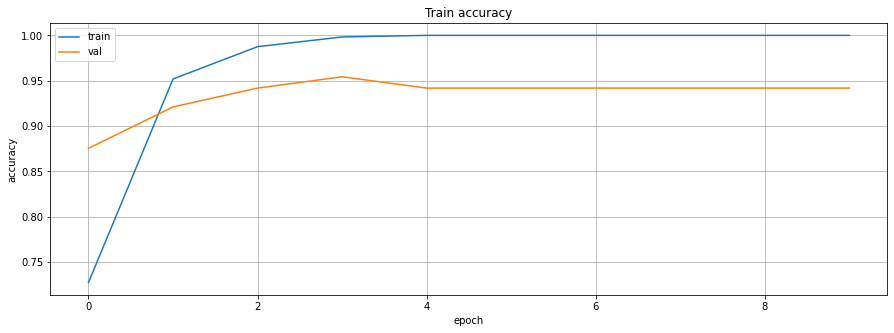

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train accuracy')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

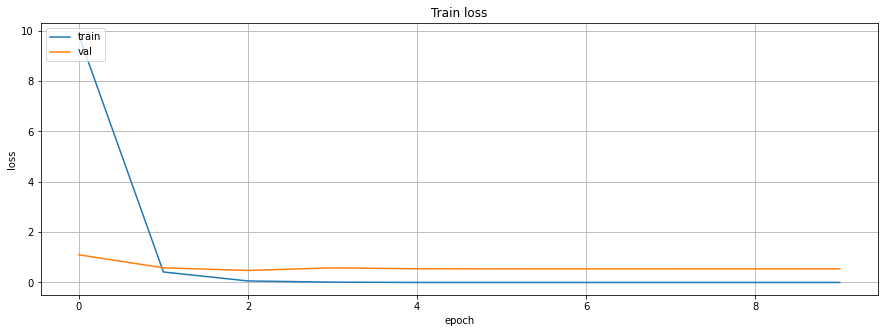

In [24]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

In [25]:
results = new_model.evaluate(X_test, y_test, batch_size = 64)
print(f"{new_model.metrics_names} = {results}")

6/6 [==============================] - 1s 143ms/step - loss: 0.6820 - accuracy: 0.9420
['loss', 'accuracy'] = [0.6819806694984436, 0.9420289993286133]


In [26]:
pred_classes = []
for x in X_test:
    res = new_model.predict(np.expand_dims(x,axis=0))
    pred = 0 if res[0][0] > res[0][1] else 1
    pred_classes.append(pred)

In [27]:
X_test_df["pred_model"] = pred_classes

len(X_test_df[X_test_df["pred_model"] == X_test_df["class"]])/len(X_test_df)

C:\Users\TeeHi\AppData\Local\Temp/ipykernel_10908/3742326457.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_df["pred_model"] = pred_classes


0.9420289855072463

In [28]:
dog_res_df = X_test_df[X_test_df["class"] == 0]
len(dog_res_df[dog_res_df["pred_model"] == dog_res_df["class"]])/len(dog_res_df)

0.9261744966442953

In [29]:
toy_res_df = X_test_df[X_test_df["class"] == 1]
len(toy_res_df[toy_res_df["pred_model"] == toy_res_df["class"]])/len(toy_res_df)

0.9540816326530612

In [30]:
def alter_model_for_GradCAM(model, last_conv_layer_name):
    last_conv_output = model.get_layer(last_conv_layer_name).output

    old_weights = [ x.numpy() for x in model.layers[-1].weights]

    new_config = model.layers[-1].get_config()
    new_config['activation'] = tf.keras.activations.linear
    new_config['name'] = 'predictions_linear'

    out_linear = tf.keras.layers.Dense(**new_config)(model.layers[-2].output)
    out_softmax = tf.keras.activations.softmax(out_linear)

    new_model = tf.keras.Model(inputs=model.inputs, outputs=[out_softmax, out_linear, last_conv_output])
    new_model.layers[-2].set_weights(old_weights)
    return new_model

In [31]:
gc_model = alter_model_for_GradCAM(new_model,"conv5_block3_3_conv")
gc_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [32]:
out_softmax = new_model.predict(np.expand_dims(X_test[0],axis=0))
out_softmax

array([[9.9999976e-01, 2.7669722e-07]], dtype=float32)

In [33]:
out_softmax, out_linear, _ = gc_model.predict(np.expand_dims(X_test[0],axis=0))
out_softmax

array([[9.9999976e-01, 2.7669722e-07]], dtype=float32)

In [34]:
def my_CNN_GradCAM(model, in_img, class_index):
    in_img = tf.cast(in_img, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(in_img)
        y_softmax, y_linear, last_conv_activation = model(in_img)
        one_class_score = y_linear[..., class_index]
    gradient = tape.gradient(one_class_score, last_conv_activation)

    gradient = gradient.numpy().squeeze(axis=0)
    alpha = np.mean(gradient, axis=(0,1))

    last_conv_activation = last_conv_activation.numpy().squeeze(axis=0)
    heatmap = np.dot(last_conv_activation, alpha)

    heatmap = np.maximum(0, heatmap)

    return heatmap

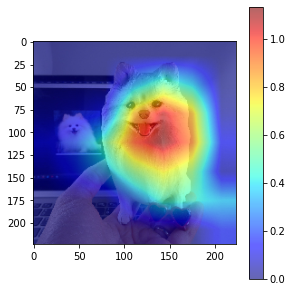

1


In [35]:
index = 5
heatmap = my_CNN_GradCAM(gc_model, np.expand_dims(X_test[index],axis=0), np.argmax(y_test[index]))

fig = plt.figure(figsize=(10,5))

ax = fig.add_subplot(1,2,1)
img = tf.keras.preprocessing.image.load_img(X_test_df["img_path"].to_list()[index], target_size=(224,224))
img = tf.keras.preprocessing.image.img_to_array(img)
ax.imshow(img.astype(np.uint8))
alpha = 0.6
im = ax.imshow(cv.resize(heatmap, img.shape[:2]), cmap="jet", alpha=alpha)
plt.colorbar(im, ax=ax)

plt.show()
print(np.argmax(y_test[index]))
